   Unnamed: 0  Store       Date  IsHoliday  Dept  Weekly_Sales  Temperature  \
0           0      1 2010-02-05          0   1.0      24924.50        42.31   
1           1      1 2010-02-05          0  26.0      11737.12        42.31   
2           2      1 2010-02-05          0  17.0      13223.76        42.31   
3           3      1 2010-02-05          0  45.0         37.44        42.31   
4           4      1 2010-02-05          0  28.0       1085.29        42.31   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0       2.572        0.0        0.0        0.0        0.0        0.0   
1       2.572        0.0        0.0        0.0        0.0        0.0   
2       2.572        0.0        0.0        0.0        0.0        0.0   
3       2.572        0.0        0.0        0.0        0.0        0.0   
4       2.572        0.0        0.0        0.0        0.0        0.0   

          CPI  Unemployment  Type    Size  
0  211.096358         8.106     3  151315  
1  2

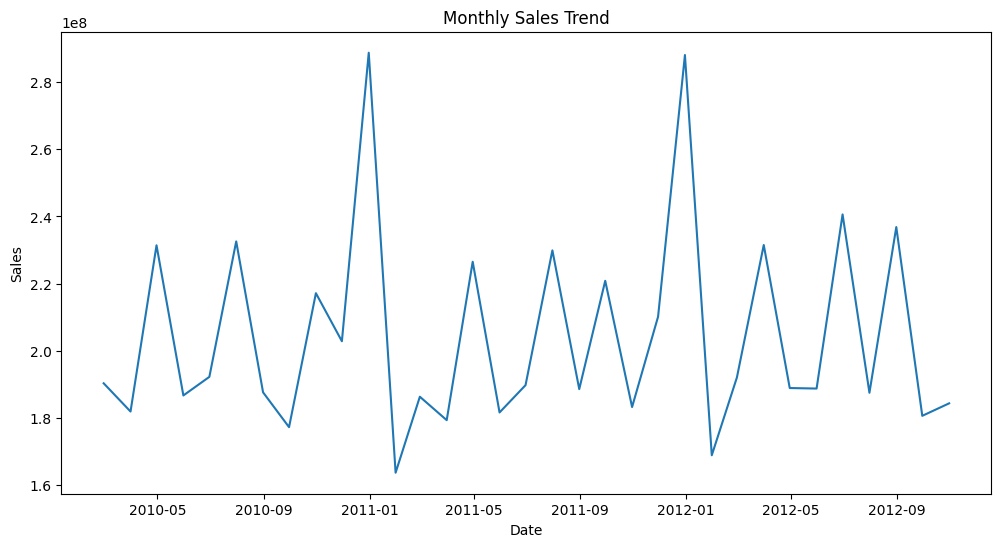

Train: 26
Test: 7


04:14:22 - cmdstanpy - INFO - Chain [1] start processing
04:14:23 - cmdstanpy - INFO - Chain [1] done processing


ARIMA MAE: 35906447.24314847
ARIMA RMSE: 37831686.35513171
Prophet MAE: 50796435.347126774
Prophet RMSE: 61782470.89031127


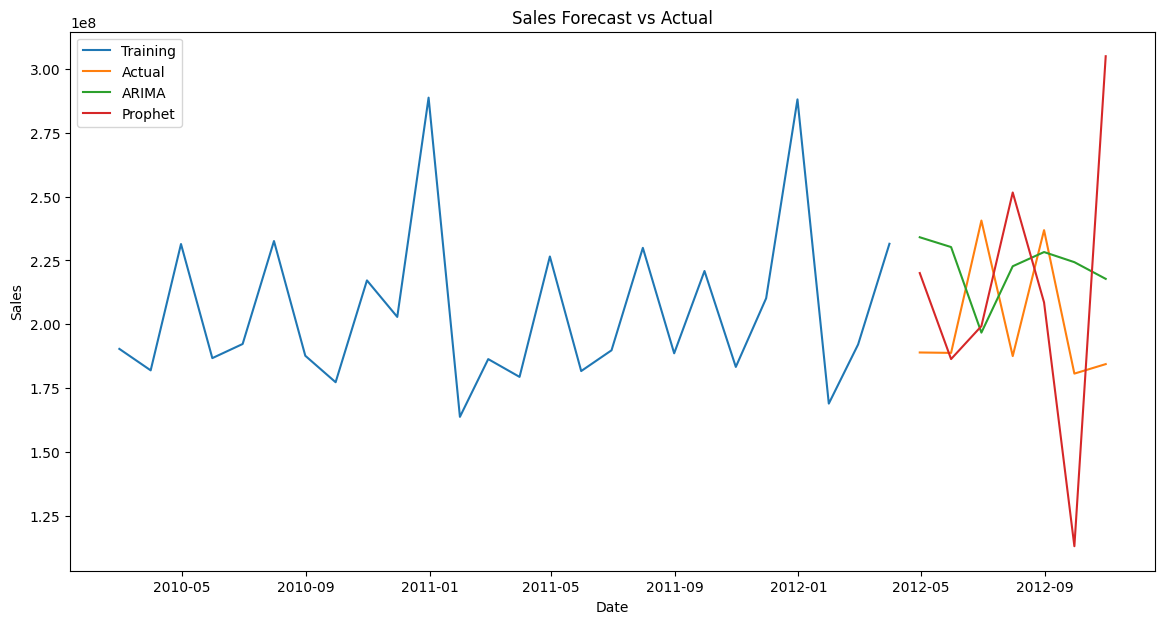

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

# =========================
# Load Data
# =========================

df = pd.read_csv(r'C:\Users\Mayur\Documents\project1\data\sales.csv')


df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

print(df.head())
print(df.columns)

# =========================
# Monthly Aggregation
# =========================

monthly_sales = (
    df
    .set_index('Date')
    .resample('ME')['Weekly_Sales']
    .sum()
    .reset_index()
)

monthly_sales.columns = ['Date', 'Sales']

print(monthly_sales.head())

# =========================
# Visualization
# =========================

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['Date'], monthly_sales['Sales'])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# =========================
# Train-Test Split
# =========================

train_size = int(len(monthly_sales)*0.8)

train = monthly_sales[:train_size]
test = monthly_sales[train_size:]

print("Train:", len(train))
print("Test:", len(test))

# =========================
# ARIMA Model
# =========================

model_arima = ARIMA(train['Sales'], order=(5,1,0))
model_fit = model_arima.fit()

forecast_arima = model_fit.forecast(steps=len(test))

# =========================
# Prophet Model
# =========================

prophet_df = monthly_sales.rename(
    columns={'Date':'ds','Sales':'y'}
)

train_p = prophet_df[:train_size]

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model_prophet.fit(train_p)

future = model_prophet.make_future_dataframe(
    periods=len(test),
    freq='ME'
)

forecast_prophet = model_prophet.predict(future)

# =========================
# Evaluation
# =========================

actual = test['Sales'].values

pred_arima = forecast_arima.values
pred_prophet = forecast_prophet['yhat'][-len(test):].values

print("ARIMA MAE:", mean_absolute_error(actual, pred_arima))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(actual, pred_arima)))

print("Prophet MAE:", mean_absolute_error(actual, pred_prophet))
print("Prophet RMSE:", np.sqrt(mean_squared_error(actual, pred_prophet)))

# =========================
# Final Plot
# =========================

plt.figure(figsize=(14,7))

plt.plot(train['Date'], train['Sales'], label='Training')
plt.plot(test['Date'], test['Sales'], label='Actual')

plt.plot(test['Date'], pred_arima, label='ARIMA')
plt.plot(test['Date'], pred_prophet, label='Prophet')

plt.title("Sales Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.savefig('../images/forecast_plot.png')
plt.show()
